In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from pylab import mpl


## Load data

In [16]:
data = pd.read_excel('./元培学院学生关系网络和集体认同调查（最终）.xlsx', sheet_name='处理后数据').iloc[: , 1:]
data['行政班级'] = data['年级'] + data['行政班级']

## Define functions and classes for calculation and simulation.

In [30]:
def distance_1(data1, data2, *length):
    if length:
        d = np.sum((data1 - data2)**2) / length
    else:
        d = np.sum((data1 - data2)**2) / data1.shape[0]
    return d

# Get distance and probability from data

def get_feature_from_data(data_,weight=1,a=[0],b=[1,2,6]):
    feature_df1 = pd.get_dummies(data_.iloc[: , a]) * weight
    feature_df1_1 = pd.get_dummies(data_.iloc[: , b])
    feature_df2 = data_.loc[: , '同班好友数': ]
    feature_df2 = (feature_df2 - feature_df2.min()) / (feature_df2.max() - feature_df2.min())
    feature_df3 = data_.iloc[: , [3, 4, 5, 7]]
    l = feature_df1.shape[1] * weight + feature_df2.shape[1] +  feature_df1_1.shape[1]+ feature_df3.shape[1]
    feature_df = pd.concat([feature_df1, feature_df1_1, feature_df2, feature_df3], axis=1)
    label_df = data_.loc[: , '元培认同感': '专业认同感']
    num = feature_df.shape[0]
    feature_values = feature_df.values
    label_values = label_df.values
    feature = []
    label = []
    for i in range(0, num):
        for j in range(0, num):
            feature.append(distance_1(feature_values[i], feature_values[j],l))
            label.append(distance_1(label_values[i], label_values[j],l))
    feature = np.array(feature).reshape(num, num)
    return feature

def get_distance(feature_value):
    feature_list = []
    l = np.size(feature_value,0)
    dist_mat = np.zeros((l,l))
    for i in range(0, l):
        for j in range(i+1, l):
            feature_list.append(distance_1(feature_value[i], feature_value[j]))
            dist_mat[i][j] = distance_1(feature_value[i], feature_value[j])
            dist_mat[j][i] = distance_1(feature_value[i], feature_value[j])
        dist_mat[i][i] = 0
    feature_npvalue = np.array(feature_list)
    dist_mat = ((dist_mat - feature_npvalue.mean()) + np.eye(l) * feature_npvalue.mean())
    return dist_mat


def p_map(d): # This is the mapping function from distance to probability
    l = np.size(d,0)
    d = d + np.eye(l)
    p = np.log(1 / d)
    p /= 20
    return p

# Calculate mean degree and mean square degree, and the predicted time constant <k> / (<k^2> - <k>)

def mean_square_degree(weight):
    l = np.shape(weight)[0]
    return sum(sum(weight) ** 2 / (2 * l))

def mean_degree(weight):
    l = np.shape(weight)[0]
    return sum(sum(weight)) / (2 * l)

def theory(distance):
    weight = p_map(distance)
    k_mean = mean_degree(weight)
    k_2_mean = mean_square_degree(weight)
    return k_mean / (k_2_mean - k_mean)

# Define network for simulation

class network():
    def __init__(self, w):
        self.w = w
        self.l = np.shape(w)[0]
    
    def initialize(self):
        first_location = np.random.randint(self.l)
        indicator = np.zeros(self.l)
        indicator[first_location] = 1.
        self.indicator = indicator

    def update(self):
        propagate_mat = np.zeros_like(self.w)
        for i in range(self.l):
            for j in range(self.l):
                propagate_mat[i][j] = float(np.random.rand() < self.w[i][j])
                if i == j:
                    propagate_mat[i][j] = 1
        _indicator = np.matmul(propagate_mat,self.indicator) > 0
        self.indicator = _indicator.astype(float)

def time(distance):
    l = np.shape(distance)[0]
    w_mat = p_map(distance)
    Net = network(w_mat)
    c = 0
    for i in range(2000):
        Net.initialize()
        count = 0
        while True:
            Net.update()
            count += 1
            if sum(Net.indicator) > l/2:
                break
        c += count
    c = c/2000
    return c

## Verify theory with simulation.

In [31]:
def p_map(d): # This is the mapping function from distance to probability
    l = np.size(d,0)
    d = d + np.eye(l)
    p = np.log(1 / d)
    p /= 50
    return p

theolist = []
simulist = []
for indexes in [[0, 1, 2, 6],[1, 2, 6],[0, 1, 6],[0, 1, 2]]: 
    feature_df1 = pd.get_dummies(data.iloc[: , indexes])
    feature_df2 = data.loc[: , '同班好友数': ]
    feature_df2 = (feature_df2 - feature_df2.min()) / (feature_df2.max() - feature_df2.min())
    feature_df3 = data.iloc[: , [3, 4, 5, 7]]
    feature_df = pd.concat([feature_df1, feature_df2, feature_df3], axis=1)
    label_df = data.loc[: , '元培认同感': '专业认同感']
    num = feature_df.shape[0]
    feature_values = feature_df.values
    label_values = label_df.values
    feature = []
    label = []
    for i in range(0, num):
        for j in range(0, num):
            feature.append(distance_1(feature_values[i], feature_values[j]))
    feature = np.array(feature).reshape(num, num)
    theolist.append(theory(feature))
    simulist.append(time(feature))

Text(0.5, 1.0, '理论模拟对照')

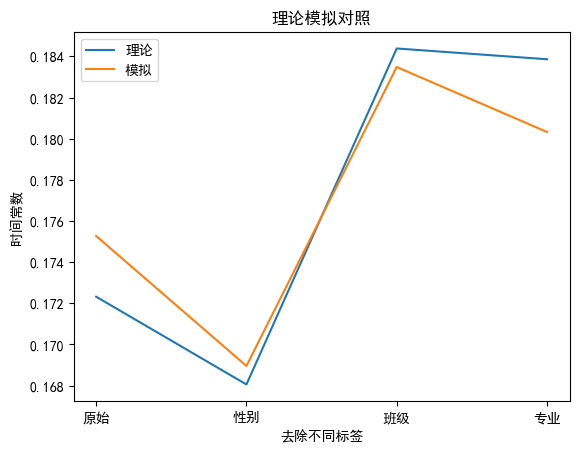

In [46]:
theolist = np.array(theolist)
simulist = np.array(simulist)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.plot(np.arange(4),theolist,label='理论')
plt.plot(np.arange(4),simulist*(theolist[1]+theolist[2])/(simulist[1]+simulist[2]),label='模拟')
plt.legend()
plt.xticks(np.arange(4),['原始','性别','班级','专业'])
plt.xlabel('去除不同标签')
plt.ylabel('时间常数')
plt.title('理论模拟对照')

## Dynamics of network and effect of each label.

Text(0.5, 1.0, '不同年级去掉不同标签后的网络传播时间常数')

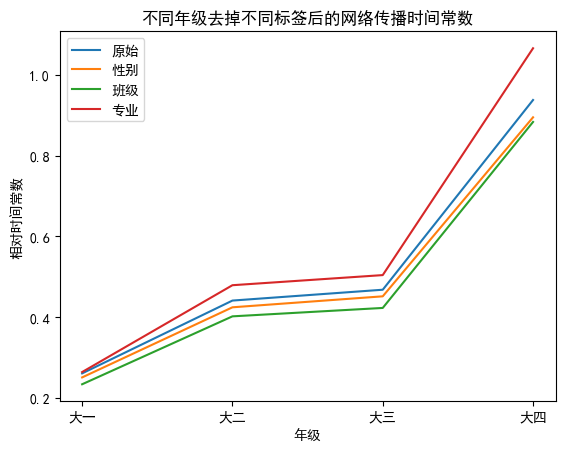

In [18]:
tau = np.zeros((4,4))
n=0
featurelist = []
class_list_list = []
for grade in ['2022级','2021级','2020级','2019级']:
    class_list = []
    data_ = data[data['年级'] == grade]
    data_ = data_.sort_values('行政班级')
    theolist = []
    for indexes in [[0, 1, 2, 6],[1, 2, 6],[0, 1, 6],[0, 1, 2]]: 
        feature_df1 = pd.get_dummies(data_.iloc[: , indexes])
        feature_df2 = data_.loc[: , '同班好友数': ]
        feature_df2 = (feature_df2 - feature_df2.min()) / (feature_df2.max() - feature_df2.min())
        feature_df3 = data_.iloc[: , [3, 4, 5, 7]]
        feature_df = pd.concat([feature_df1, feature_df2, feature_df3], axis=1)
        label_df = data_.loc[: , '元培认同感': '专业认同感']
        num = feature_df.shape[0]
        feature_values = feature_df.values
        label_values = label_df.values
        feature = []
        label = []
        for i in range(0, num):
            for j in range(0, num):
                feature.append(distance_1(feature_values[i], feature_values[j]))
        feature = np.array(feature).reshape(num, num)
        if indexes == [0, 1, 2, 6]:
            class_num=len(sorted(list(set(data_['行政班级'].values))))
            for i in range(class_num):
                class_list.append(np.sum(feature_values,0)[2+i])
            class_list = np.array(class_list)
            class_list_list.append(class_list)
            featurelist.append(feature)
        theolist.append(theory(feature))
    theolist = np.array(theolist)
    tau[n] = theolist
    n += 1
tau = tau.transpose()
labels = ['原始','性别','班级','专业']
plt.rcParams['font.sans-serif'] = ['SimHei']
for i in range(4):
    plt.plot(np.arange(4),tau[i],label=labels[i])
plt.legend()
plt.xticks(np.arange(4),['大一','大二','大三','大四'])
plt.xlabel('年级')
plt.ylabel('相对时间常数')
plt.title('不同年级去掉不同标签后的网络传播时间常数')

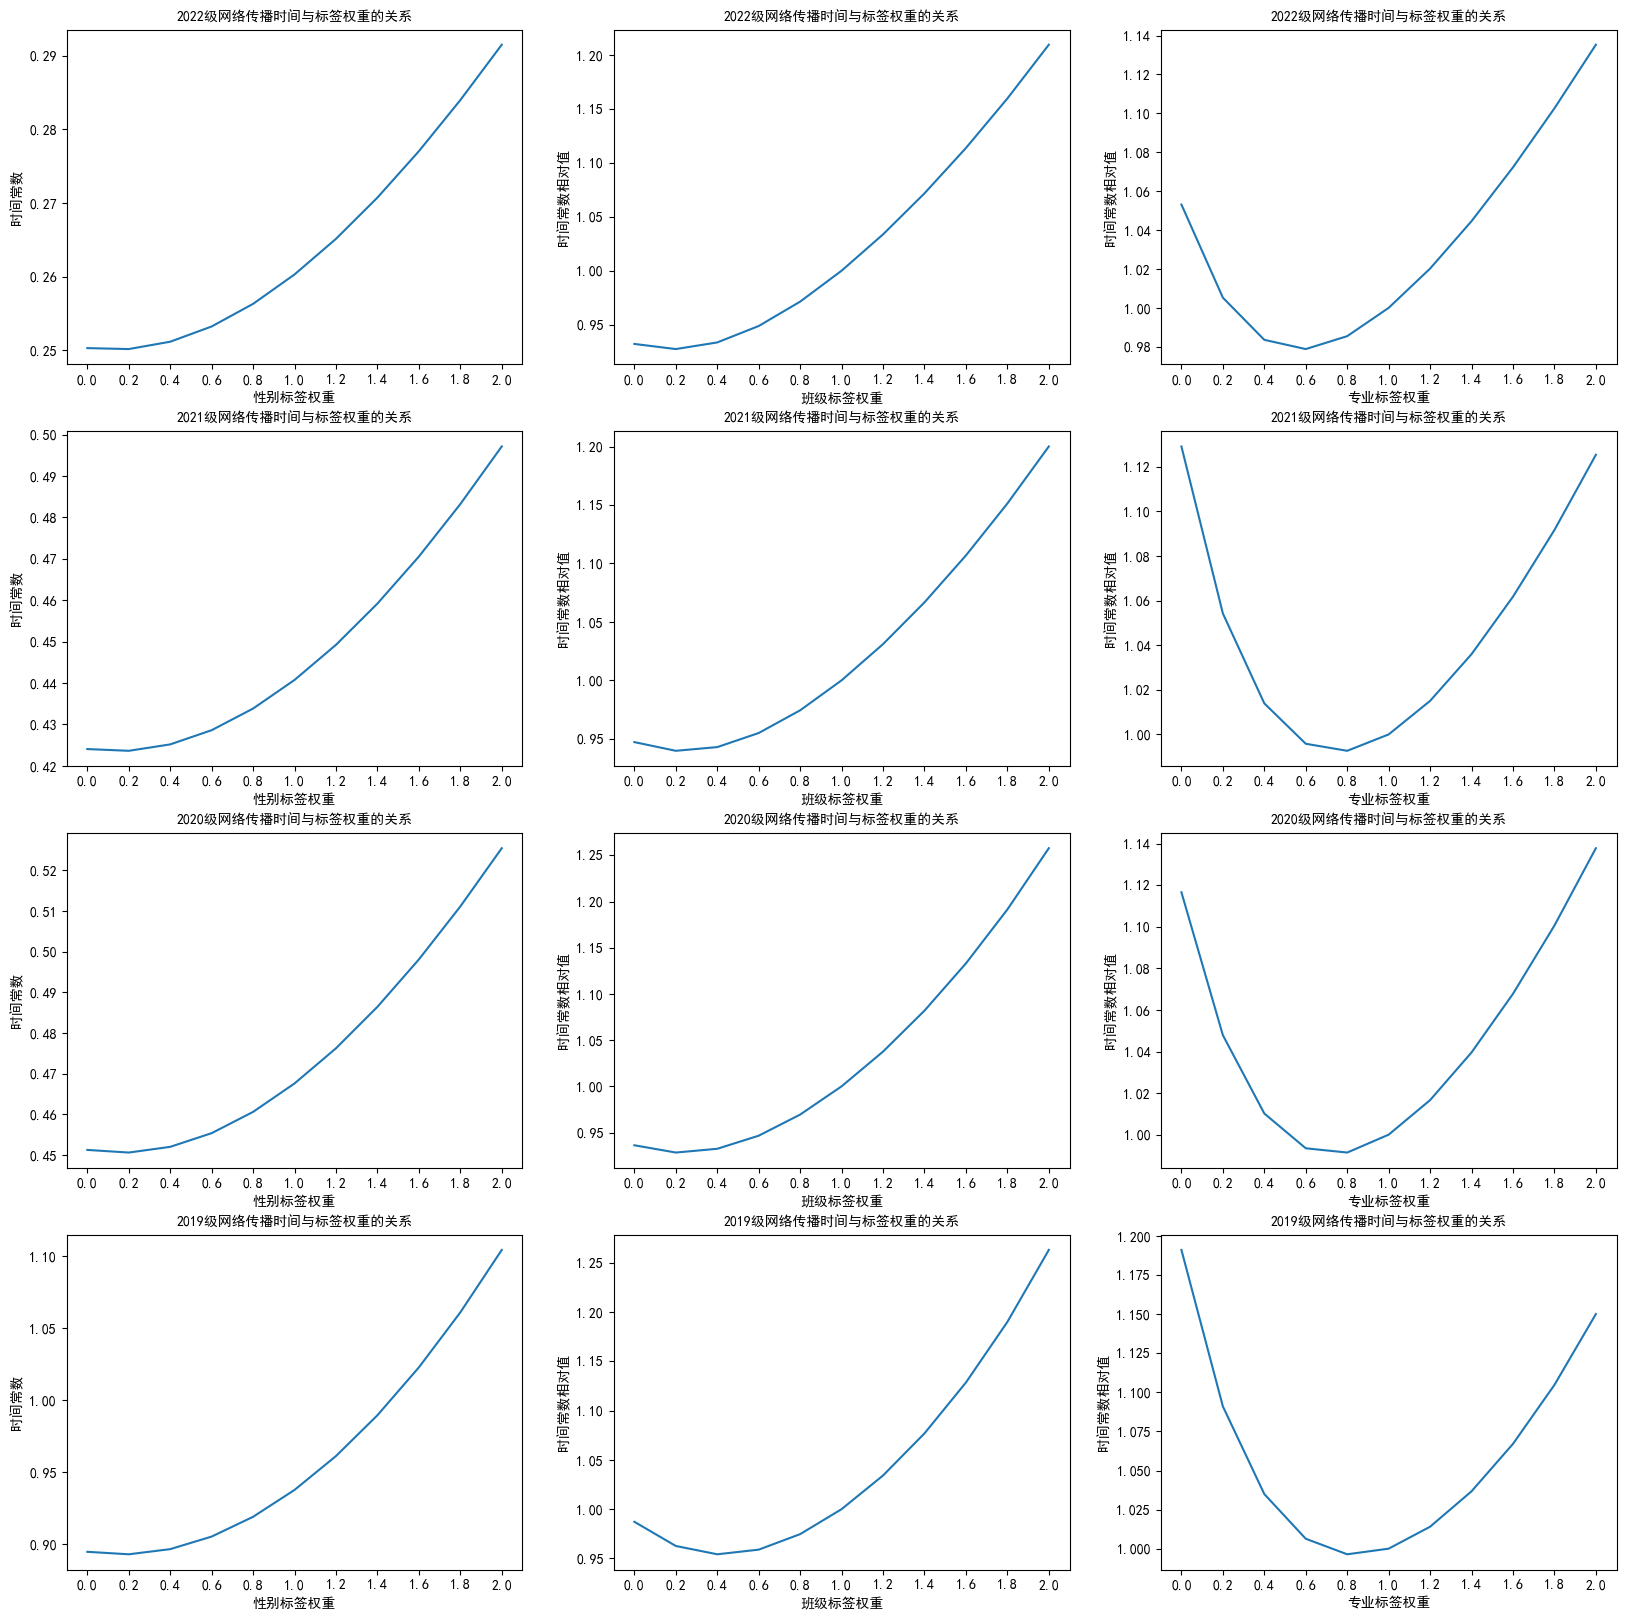

In [22]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定宋体为默认字体
plt.figure(figsize=(20,20))
n = 1
for grade in ['2022级','2021级','2020级','2019级']:
    data_ = data[data['年级'] == grade]
    for al in range(3):
        theolist = []
        if al == 0:
            a = [0]
            b = [1,2,6]
            lb = '性别'
        elif al == 1:
            a = [2]
            b = [0,1,6]
            lb = '班级'
        else:
            a = [6]
            b = [0,1,2]
            lb = '专业'
        for weight in [0., 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]: 
            feature = get_feature_from_data(data_,weight,a,b)
            theolist.append(theory(feature))
    
        if al == 0:
            theolist = np.array(theolist)
            normalizelist = theolist
            yl = ''
        else:
            theolist = theolist/normalizelist
            yl = '相对值'
        plt.subplot(4,3,3*n+al-2)
        x = np.arange(np.size(theolist))
        plt.plot(x,theolist)
        plt.title(grade+'网络传播时间与标签权重的关系', fontproperties="SimHei")
        plt.xticks(np.arange(11),np.arange(11)/5)
        plt.xlabel(lb+'标签权重', fontproperties="SimHei")
        plt.ylabel('时间常数'+yl, fontproperties="SimHei")
    n+=1

## Visualize a network

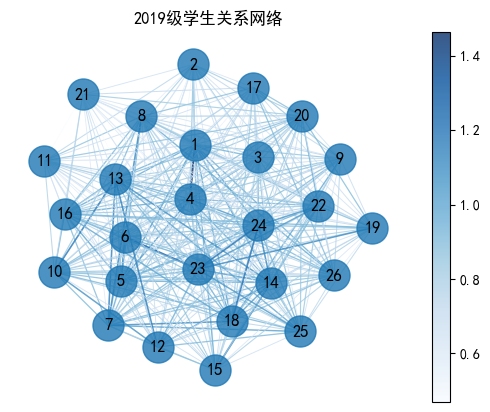

In [20]:
p = p_map(featurelist[3])*10
l = np.shape(p)[0]
G = nx.Graph()
for i in range(l):
    G.add_node(l)
    for j in range(i):
        G.add_edge(i,j)
        G.edges[i, j]['weight'] = p[i,j]
G.remove_node(l)

color_map = ['red', 'green', 'blue', 'yellow', 'pink', 'purple', 'cyan'] 

# 绘制图形，根据边的权重来确定线条颜色和粗细
pos = nx.spring_layout(G)
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
nx.draw_networkx_nodes(G, pos, node_size=500, alpha=0.8) #node_color=, 
edges = nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, edge_color=weights, edge_cmap=plt.cm.Blues, alpha=0.8)
plt.colorbar(edges)
plt.title('2019级学生关系网络')
plt.axis('off')

# 添加节点标签
labels = {}
for i in range(np.shape(p)[0]):
    labels[i] = i+1
nx.draw_networkx_labels(G, pos, labels=labels, font_size=12)

# 设置颜色映射 
color_map = ['red', 'green', 'blue', 'yellow', 'pink', 'purple', 'cyan'] 

# 显示图形
plt.show()
